# Fashion MNIST Classification using ResNet-50

## Project Overview
This project focuses on classifying images from the Fashion MNIST dataset using a pre-trained ResNet-50 model. The first four layers of the ResNet-50 model are made trainable to fine-tune the network for better performance on the Fashion MNIST dataset. Additionally, two fully connected layers are added to the model. Parallel computing is enabled to speed up the training process.

## Steps Involved

1. **Data Preparation**
   - Load the Fashion MNIST dataset.
   - Preprocess the images (normalization, resizing, etc.).

2. **Model Setup**
   - Load the pre-trained ResNet-50 model.
   - Modify the model to make the first four layers trainable.
   - Add two fully connected layers:
     - The first layer takes 2048 inputs and outputs 512.
     - The second layer takes 512 inputs and outputs the number of classes.

3. **Training**
   - Enable parallel computing to utilize multiple GPUs/CPUs.
   - Compile the model with appropriate loss function and optimizer.
   - Train the model on the Fashion MNIST dataset.

4. **Saving Model**
   - Saving Model Parameters and State in PyTorch.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

### Plotting Loss and Accuracy

#### Function Overview
The `plot_stuff` function is designed to plot two metrics, total loss and accuracy, on the same graph but with different y-axes. This allows for a clear visualization of how both metrics change over iterations during the training process.

#### Code Explanation:

1. **Creating the Figure and Axes:**
    ```python
        fig, ax1 = plt.subplots()
    ```
    -  This line creates a figure and a set of subplots. `ax1` is the primary y-axis.

2. **Plotting Total Loss:**

    - `color = 'tab:red'`: Sets the color for the total loss plot to red.
    - `ax1.plot(COST, color=color)`: Plots the `COST` data on the primary y-axis (`ax1`) with the specified red color.
    - `ax1.set_xlabel('Iteration', color=color)`: Labels the x-axis as 'Iteration' and sets the label color to red.
    - `ax1.set_ylabel('total loss', color=color)`: Labels the primary y-axis as 'total loss' and sets the label color to red.
    - `ax1.tick_params(axis='y', color=color)`: Sets the color of the y-axis ticks to red.

3. **Plotting Total Accuracy:**
    - `ax2 = ax1.twinx()`: Creates a secondary y-axis (`ax2`) that shares the same x-axis as `ax1`.
    - `color = 'tab:blue'`: Sets the color for the accuracy plot to blue.
    - `ax2.plot(ACC, color=color)`: Plots the `ACC` data on the secondary y-axis (`ax2`) with the specified blue color.
    - `ax2.set_ylabel('accuracy', color=color)`: Labels the secondary y-axis as 'accuracy' and sets the label color to blue.
    - `ax2.tick_params(axis='y', color=color)`: Sets the color of the secondary y-axis ticks to blue.

4. **Adjusting Layout and Displaying the Plot:**
    - `fig.tight_layout()`: Adjusts the layout of the figure to prevent overlap between elements, ensuring a clean and readable plot.
    - `plt.show()`: Displays the plot.


In [ ]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.plot(ACC, color = color)
    ax2.set_ylabel('accuracy', color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()
    
    plt.show()

### Displaying an Image Tensor

#### Function Overview
The `imshow_` function is designed to display an image tensor using Matplotlib. It handles the conversion of the tensor to a NumPy array, applies normalization, and then displays the image.

#### Code Explanation

1. **Function Definition and Docstring:**
    - `def imshow_(inp, title=None)`: Defines a function named imshow_ that takes an input tensor inp and an optional title.

2. **Permuting and Converting to NumPy Array:**
    - `inp.permute(1, 2, 0)`: Changes the order of dimensions of the tensor from (C, H, W) to (H, W, C) to match the format expected by Matplotlib.
    - `numpy()`: Converts the tensor to a NumPy array.
    - `print(inp.shape)`: Prints the shape of the NumPy array for debugging purposes.

3. **Normalization:**
    - `mean = np.array([0.485, 0.456, 0.406])`: Defines the mean used for normalization.
    - `std = np.array([0.229, 0.224, 0.225])`: Defines the standard deviation used for normalization.
    - `inp = std * inp + mean`: Applies the normalization to the image.
    - `inp = np.clip(inp, 0, 1)`: Clips the values to be between 0 and 1 to ensure valid image pixel values.

4. **Displaying the Image:**
    - `plt.imshow(inp)`: Displays the image using Matplotlib.
    - `if title is not None: plt.title(title)`: Sets the title of the image if provided.
    - `plt.pause(0.001)`: Pauses the plot for a brief moment to ensure it updates.
    - `plt.show()`: Displays the plot.

In [6]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

### Model Prediction and Result Comparison

#### Function Overview
The `result` function takes a model, an input tensor `x`, and the true label `y`. It predicts the label using the model and compares it with the true label, printing the result if the prediction is incorrect.

#### Code Explanation

1. **Function Definition and Comment**:
    - `def result(model, x, y):`: Defines a function named `result` that takes three arguments: `model`, `x`, and `y`.
    - `# x, y = sample`: A comment indicating that `x` and `y` are a sample input and its corresponding label.

2. **Model Prediction**:
    - `x.unsqueeze_(0)`: Adds a batch dimension to the input tensor `x`, making it compatible with the model's expected input shape.
    - `z = model(x.unsqueeze_(0))`: Passes the input tensor through the model to get the output `z`.

3. **Finding the Predicted Label**:
    - `torch.max(z.data, 1)`: Computes the maximum value along the second dimension (class dimension) of the output tensor `z`. It returns a tuple where the first element is the maximum value and the second element is the index of the maximum value (predicted class).
    - `_, yhat`: Unpacks the tuple, ignoring the maximum value and keeping the index of the maximum value as `yhat`.

4. **Comparing Prediction with True Label**:
    - `if yhat.item() != y`: Checks if the predicted label `yhat` is not equal to the true label `y`.
    - `print(f"predicted: {str(yhat.item())} actual: {y}")`: Prints the predicted label and the true label if they do not match.


In [7]:
def result(model,x,y):
    #x,y=sample
    z = model(x.unsqueeze_(0))
    _, yhat = torch.max(z.data, 1)
    
    if yhat.item() != y:
        print(f"predicted: {str(yhat.item())} actual: {y}")

### Setting the Device for PyTorch:

**Explanation:**
-    `torch.device("cuda:0" if torch.cuda.is_available() else "cpu")`: This line checks if a CUDA-enabled GPU is available. If it is, it sets the device to the first GPU `("cuda:0")`. If not, it defaults to the CPU (`"cpu"`).
-    `torch.cuda.is_available()`: Returns True if a CUDA-enabled GPU is available, otherwise False.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


## 1. Data Preparation:

### Loading and Transforming the FashionMNIST Dataset

#### Code Explanation

1.  **Setting the Image Size**:
    - `IMAGE_SIZE = 16`: Defines a constant `IMAGE_SIZE` with a value of 16. This will be used to resize the images to 16x16 pixels.

3. **Composing the Transformations**:
    - `transforms.Compose([...])`: Creates a composition of several image transformations.
    - `transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))`: Resizes the images to 16x16 pixels.
    - `transforms.ToTensor()`: Converts the images to PyTorch tensors.
    - `transforms.Normalize((0.5,), (0.5,))`: Normalizes the images with a mean of 0.5 and a standard deviation of 0.5.

4. **Loading the Training Dataset**:
    - `dsets.FashionMNIST(...)`: Loads the FashionMNIST dataset.
    - `root='./data'`: Specifies the directory where the dataset will be stored.
    - `train=True`: Indicates that this is the training set.
    - `download=True`: Downloads the dataset if it is not already present in the specified directory.
    - `transform=composed`: Applies the composed transformations to the dataset.

5. **Loading the Validation Dataset**:
    - `train=False`: Indicates that this is the validation (or test) set.
    - The other parameters are the same as for the training set.


In [9]:
import torchvision.datasets as dsets

IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)
val_set = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

In [ ]:
n_epochs = 25
batch_size = 500

lr = 0.0001

momentum = 0.8

lr_scheduler = True
base_lr = 0.001
max_lr = 0.01

### Building training function of Model with PyTorch:

#### Function Overview
The `train_model` function trains a PyTorch model using the provided training and validation data loaders, criterion, optimizer, and number of epochs. It tracks the loss and accuracy during training and validation, and saves the best model weights based on validation accuracy.

#### Code Explanation

1. **Function Definition and Initialization**

    - `import copy`: Imports the `copy` module to allow deep copying of the model's state dictionary.
    - `def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True):`: Defines the `train_model` function with the specified parameters.
    - `loss_list = []`: Initializes an empty list to store the loss values for each epoch.
    - `accuracy_list = []`: Initializes an empty list to store the accuracy values for each epoch.
    - `correct = 0`: Initializes a variable to count the number of correct predictions.
    - `n_test = len(val_set)`: Calculates the number of samples in the validation set.
    - `accuracy_best = 0`: Initializes a variable to store the best validation accuracy.
    - `best_model_wts = copy.deepcopy(model.state_dict())`: Creates a deep copy of the model's initial state dictionary to save the best model weights.
2. **Training Loop: Epoch Loop and Batch Loop:**
    - `print("The first epoch should take several minutes")`: Prints a message indicating that the first epoch may take some time.
    - `for epoch in tqdm(range(n_epochs)):`: Loops through the specified number of epochs, displaying a progress bar with `tqdm`.
    - `loss_sublist = []`: Initializes an empty list to store the loss values for the current epoch.
    - `for x, y in train_loader:`: Loops through the batches of data in the training loader.
    - `x, y = x.to(device), y.to(device)`: Moves the input data and labels to the specified device (CPU or GPU).
    - `model.train()`: Sets the model to training mode.
    - `x = x.repeat(1, 3, 1, 1)`: Repeats the input tensor along the channel dimension to match the expected input shape of the model.
    - `z = model(x)`: Performs a forward pass through the model.
    - `loss = criterion(z, y)`: Calculates the loss using the specified criterion.
    - `loss_sublist.append(loss.data.item())`: Appends the loss value to the list for the current epoch.
    - `loss.backward()`: Performs backpropagation to compute the gradients.
    - `optimizer.step()`: Updates the model parameters using the optimizer.
    - `optimizer.zero_grad()`: Resets the gradients to zero.
    - `print("epoch {} done".format(epoch))`: Prints a message indicating that the current epoch is done.

3. **Validation Loop: Scheduler Step, Loss Calculation and Validation Batch Loop:**
    - `schedule.step()`: Updates the learning rate scheduler.
    - `loss_list.append(np.mean(loss_sublist))`: Appends the mean loss for the current epoch to the loss list.
    - `correct = 0`: Resets the correct predictions counter.
    - `for x_test, y_test in validation_loader:`: Loops through the batches of data in the validation loader.
    - `x_test, y_test = x_test.to(device), y_test.to(device)`: Moves the input data and labels to the specified device (CPU or GPU).
    - `model.eval()`: Sets the model to evaluation mode.
    - `x_test = x_test.repeat(1, 3, 1, 1)`: Repeats the input tensor along the channel dimension to match the expected input shape of the model.
    - `z = model(x_test)`: Performs a forward pass through the model.
    - `_, yhat = torch.max(z.data, 1)`: Gets the predicted class with the highest score.
    - `correct += (yhat == y_test).sum().item()`: Counts the number of correct predictions.
    - `accuracy = correct / n_test`: Calculates the accuracy for the current epoch.
    - `accuracy_list.append(accuracy)`: Appends the accuracy for the current epoch to the accuracy list.
    - `if accuracy > accuracy_best:`: Checks if the current accuracy is better than the best accuracy.
    - `accuracy_best = accuracy`: Updates the best accuracy.
    - `best_model_wts = copy.deepcopy(model.state_dict())`: Saves the current model weights as the best model weights.

4. **Printing and Returning Results:**
    - `if print_:`: Checks if the `print_` flag is set to `True`.
    - `print('learning rate', optimizer.param_groups[0]['lr'])`: Prints the current learning rate.
    - `print("The validation Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))`: Prints the mean loss for the current epoch.
    - `print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))`: Prints the accuracy for the current epoch.
    - `model.load_state_dict(best_model_wts)`: Loads the best model weights.
    - `return accuracy_list, loss_list, model`: Returns the accuracy list, loss list, and the trained model.

In [11]:
import copy

def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        
        # Loop through the data in loader
        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            
            model.train() 
            x = x.repeat(1, 3, 1, 1)
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        schedule.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            x_test = x_test.repeat(1, 3, 1, 1)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

## 2. Model Setup:

1. **Loading the Pretrained Model:**
- `model = models.resnet50(pretrained=True)`: Loads a pretrained ResNet50 model from the `torchvision.models` module.

2. **Setting Requires Grad for Specific Layers:**
    ##### Enabling Gradient Computation:
    - Loops through the named children of the model.
    - Enables gradient computation for the layers `conv1`, `bn1`, `relu`, and `maxpool` by setting `requires_grad` to `True`.

    ##### Disabling Gradient Computation:
    - Loops through the named children of the model.
    - Disables gradient computation for all layers except `conv1`, `bn1`, `relu`, and `maxpool` by setting `requires_grad` to `False`.

3. **Determining the Number of Classes:**
    - Assumes `train_set` is a DataLoader or similar object.
    - `n_classes = len(set(train_set.targets.numpy()))`: Calculates the number of unique classes in the training set by converting the targets to a NumPy array and using `set` to find unique values.

4. **Defining a Custom Model Class:**
    - Defines a custom neural network class `Model` that inherits from `nn.Module`.
    - The `__init__` method initializes two fully connected layers (`fc1` and `fc2`).
    - The `forward` method defines the forward pass, applying ReLU activation to the output of `fc1` and passing it through `fc2`.

5. **Replacing the Fully Connected Layer of ResNet50:**
    - `model.fc = Model(...)`: Replaces the fully connected layer of the ResNet50 model with an instance of the custom `Model` class that we create in step 4.
        - `Model(2048, 10, n_classes)`: Sets the input size to 2048, hidden size to 512, and output size to the number of classes (`n_classes`).


In [12]:
model = models.resnet50(pretrained=True)

In [14]:
for name, layer in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool']:
        layer.requires_grad = True

In [15]:
for name, layer in model.named_children():
    if name not in ['conv1', 'bn1', 'relu', 'maxpool']:
        layer.requires_grad  = False

In [ ]:
n_classes = len(set(train_set.targets.numpy()))
print(n_classes)


10


In [17]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model.fc = Model(2048, 512, n_classes)

## 3. Training:

### 1. Configuring PyTorch for Multi-threading and Data Parallelism

1. **Setting the Number of Threads:**
- `torch.set_num_threads(3)`: Sets the number of threads used for intra-op parallelism on CPU to 3. This can help control the amount of CPU resources used by PyTorch operations.

2. **Wrapping the Model with DataParallel:**
- `model = DataParallel(model)`: Wraps the model with `DataParallel`, enabling it to utilize multiple GPUs for training and inference.

#. **Moving the Model to the Device:**
- `model.to(device)`: Moves the model to the specified device (CPU or GPU). This ensures that the model computations are performed on the appropriate hardware.


In [35]:
torch.set_num_threads(3)

In [ ]:
from torch.nn import DataParallel

model = DataParallel(model)

In [34]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
from torchsummary import summary

summary(model, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]           9,408
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5             [-1, 64, 4, 4]           4,096
       BatchNorm2d-6             [-1, 64, 4, 4]             128
              ReLU-7             [-1, 64, 4, 4]               0
            Conv2d-8             [-1, 64, 4, 4]          36,864
       BatchNorm2d-9             [-1, 64, 4, 4]             128
             ReLU-10             [-1, 64, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]          16,384
      BatchNorm2d-12            [-1, 256, 4, 4]             512
           Conv2d-13            [-1, 256, 4, 4]          16,384
      BatchNorm2d-14            [-1, 25

### 2. Setting Up Training Components for PyTorch

1. **Defining the Loss Function:**
    - `criterion = nn.CrossEntropyLoss()`: Initializes the cross-entropy loss function, which is commonly used for classification tasks.

2. **Creating Data Loaders:**
    1. **Training Data Loader:**
        - `torch.utils.data.DataLoader(...)`: Creates a data loader for the training dataset.
            - `dataset=train_set`: Specifies the training dataset.
            - `batch_size=batch_size`: Sets the batch size for loading data.
            - `num_workers=4`: Uses 4 subprocesses for data loading.
            - `shuffle=True`: Shuffles the data at every epoch.

    2. **Validation Data Loader:**
        - `torch.utils.data.DataLoader(...)`: Creates a data loader for the validation dataset.
            - `dataset=val_set`: Specifies the validation dataset.
            - `batch_size=2500`: Sets the batch size for loading data. Here, a larger batch size is used for validation.

3. **Setting Up the Optimizer:**
    - `torch.optim.SGD(...)`: Initializes the Stochastic Gradient Descent (SGD) optimizer.
        - `model.parameters()`: Passes the model parameters to the optimizer.
        - `lr=lr`: Sets the learning rate.
        - `momentum=momentum`: Sets the momentum factor.

4. **Configuring the Learning Rate Scheduler:**
    - `if lr_scheduler:`: Checks if a learning rate scheduler is provided.
    - `lr_scheduler.CyclicLR(...)`: Initializes a cyclic learning rate scheduler.
        - `optimizer`: Passes the optimizer to the scheduler.
        - `base_lr=0.001`: Sets the base learning rate.
        - `max_lr=0.01`: Sets the maximum learning rate.
        - `step_size_up=5`: Defines the number of training iterations in the increasing half of a cycle.
        - `mode="triangular2"`: Uses the "triangular2" mode for the learning rate schedule, which halves the cycle amplitude after each cycle.

In [21]:
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, num_workers=4, shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=2500)

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
if lr_scheduler:
    schedule = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01 ,step_size_up=5, mode="triangular2")

In [25]:
from datetime import datetime
import time

### 3. Train the Model with Fashion MNISt Dataset

1. **Recording Start Time:**
    - `start_datetime = datetime.now()`: Records the current date and time.
    - `start_time = time.time()`: Records the current time in seconds since the epoch.

2. **Training the Model:**
    - `accuracy_list, loss_list, model = train_model(...)`: Calls the `train_model` function to train the model and returns the accuracy list, loss list, and the trained model.

3. **Recording End Time and Calculating Elapsed Time:**
    - `end_datetime = datetime.now()`: Records the current date and time after training.
    - `current_time = time.time()`: Records the current time in seconds since the epoch after training.
    - `elapsed_time = current_time - start_time`: Calculates the elapsed time by subtracting the start time from the current time.
    - `print(f"elapsed time {elapsed_time} seconds")`: Prints the elapsed time in seconds.


In [ ]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list, loss_list, model = train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print(f"elapsed time {elapsed_time} seconds")

The first epoch should take several minutes


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 0 done


  4%|▍         | 1/25 [11:22<4:32:56, 682.35s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 1.7389411066969236
The validation accuracy for epoch 1: 0.7267
epoch 1 done


  8%|▊         | 2/25 [22:57<4:24:21, 689.62s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.5660248870650927
The validation accuracy for epoch 2: 0.8451
epoch 2 done


 12%|█▏        | 3/25 [34:34<4:14:09, 693.14s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.35739033396045367
The validation accuracy for epoch 3: 0.8653
epoch 3 done


 16%|█▌        | 4/25 [46:15<4:03:40, 696.21s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.28974730807046095
The validation accuracy for epoch 4: 0.8697
epoch 4 done


 20%|██        | 5/25 [1:42:15<9:12:20, 1657.03s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.25251910934845606
The validation accuracy for epoch 5: 0.8846
epoch 5 done


 24%|██▍       | 6/25 [1:57:16<7:23:19, 1399.99s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.22366891739269099
The validation accuracy for epoch 6: 0.8826
epoch 6 done


 28%|██▊       | 7/25 [2:09:42<5:55:50, 1186.13s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.19029672021667163
The validation accuracy for epoch 7: 0.8843
epoch 7 done


 32%|███▏      | 8/25 [2:22:11<4:56:37, 1046.90s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.15487331661085288
The validation accuracy for epoch 8: 0.8835
epoch 8 done


 36%|███▌      | 9/25 [2:34:21<4:12:44, 947.81s/it] 

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.12209109881271919
The validation accuracy for epoch 9: 0.8877
epoch 9 done


 40%|████      | 10/25 [2:47:12<3:43:19, 893.31s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.08412672293682893
The validation accuracy for epoch 10: 0.8963
epoch 10 done


 44%|████▍     | 11/25 [3:00:23<3:21:04, 861.76s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 11: 0.052369569630051654
The validation accuracy for epoch 11: 0.8959
epoch 11 done


 48%|████▊     | 12/25 [3:12:55<2:59:31, 828.58s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 12: 0.04526156027180453
The validation accuracy for epoch 12: 0.894
epoch 12 done


 52%|█████▏    | 13/25 [3:25:30<2:41:14, 806.23s/it]

learning rate 0.003699999999999999
The validaion  Cost for each epoch 13: 0.05403527707482378
The validation accuracy for epoch 13: 0.8905
epoch 13 done


 56%|█████▌    | 14/25 [3:38:16<2:25:35, 794.15s/it]

learning rate 0.0046
The validaion  Cost for each epoch 14: 0.07638472790519396
The validation accuracy for epoch 14: 0.8874
epoch 14 done


 60%|██████    | 15/25 [3:50:51<2:10:23, 782.31s/it]

learning rate 0.0055000000000000005
The validaion  Cost for each epoch 15: 0.09293010666345557
The validation accuracy for epoch 15: 0.8834
epoch 15 done


 64%|██████▍   | 16/25 [4:02:10<1:52:39, 751.10s/it]

learning rate 0.0046
The validaion  Cost for each epoch 16: 0.08838076681519548
The validation accuracy for epoch 16: 0.89
epoch 16 done


 68%|██████▊   | 17/25 [4:13:24<1:37:04, 728.12s/it]

learning rate 0.003699999999999999
The validaion  Cost for each epoch 17: 0.07098564437280099
The validation accuracy for epoch 17: 0.8879
epoch 17 done


 72%|███████▏  | 18/25 [4:25:07<1:24:02, 720.38s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 18: 0.05316129820421338
The validation accuracy for epoch 18: 0.8919
epoch 18 done


 76%|███████▌  | 19/25 [4:37:25<1:12:35, 725.85s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 19: 0.03347059735096991
The validation accuracy for epoch 19: 0.8882
epoch 19 done


 80%|████████  | 20/25 [4:49:50<1:00:57, 731.48s/it]

learning rate 0.001
The validaion  Cost for each epoch 20: 0.01969384690746665
The validation accuracy for epoch 20: 0.8967
epoch 20 done


 84%|████████▍ | 21/25 [5:01:33<48:11, 722.93s/it]  

learning rate 0.0014500000000000006
The validaion  Cost for each epoch 21: 0.010432205465622246
The validation accuracy for epoch 21: 0.8977
epoch 21 done


 88%|████████▊ | 22/25 [5:13:24<35:57, 719.24s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 22: 0.007580066672138249
The validation accuracy for epoch 22: 0.8979
epoch 22 done


 92%|█████████▏| 23/25 [5:25:15<23:53, 716.74s/it]

learning rate 0.0023499999999999997
The validaion  Cost for each epoch 23: 0.0076549584521368765
The validation accuracy for epoch 23: 0.8926
epoch 23 done


 96%|█████████▌| 24/25 [5:37:00<11:53, 713.34s/it]

learning rate 0.0027999999999999995
The validaion  Cost for each epoch 24: 0.011201865472442781
The validation accuracy for epoch 24: 0.8953
epoch 24 done


100%|██████████| 25/25 [5:49:06<00:00, 837.86s/it]

learning rate 0.0032500000000000003
The validaion  Cost for each epoch 25: 0.018516570725478233
The validation accuracy for epoch 25: 0.8935
elapsed time 20946.646594762802


# 4. Saving Model:
## Saving Model Parameters and State in PyTorch

1. **Defining Training Parameters:**
  - `parameters = {...}`: Creates a dictionary to store various training parameters.
    - `'epochs': n_epochs`: Stores the number of epochs.
    - `'learningRate': lr`: Stores the learning rate.
    - `'momentum': momentum`: Stores the momentum value.
    - `'learningRatescheduler': {...}`: Stores the learning rate scheduler parameters.
      - `"lr_scheduler": lr_scheduler`: Indicates if a learning rate scheduler is used.
      - `"base_lr": base_lr`: Stores the base learning rate.
      - `"max_lr": max_lr`: Stores the maximum learning rate.

2. **Saving the Model State:**
  - `torch.save({...}, 'FashionMNISTClassificationModel.pt')`: Saves the model and its state to a file named `FashionMNISTClassificationModel.pt`.
    - `'epoch': n_epochs`: Saves the number of epochs.
    - `'optimizer_state_dict': optimizer.state_dict()`: Saves the state dictionary of the optimizer.
    - `'model': model`: Saves the model itself.
    - `'conv1': model.conv1`: Saves the first convolutional layer of the model.
    - `'bn1': model.bn1`: Saves the first batch normalization layer of the model.
    - `'relu': model.relu`: Saves the ReLU activation layer of the model.
    - `'maxpool': model.maxpool`: Saves the max pooling layer of the model.
    - `'model_state_dict': model.state_dict()`: Saves the state dictionary of the model.
    - `'loss': loss_list`: Saves the list of loss values.
    - `'accuracy': accuracy_list`: Saves the list of accuracy values.
    - `'parameters': parameters`: Saves the dictionary of training parameters.
  - `'FashionMNISTClassificationModel.pt'`: is the PATH of the saved model

In [ ]:
parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    #'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
}

In [ ]:
# Save the model to FashionMNISTClassificationModel.pt
torch.save({
    'epoch': n_epochs,
    'optimizer_state_dict': optimizer.state_dict(),
    'model': model,
    'conv1': model.conv1,
    'bn1': model.bn1,
    'relu': model.relu,
    'maxpool': model.maxpool,
    'model_state_dict': model.state_dict(),
    'loss': loss_list,
    'accuracy': accuracy_list,
    'parameters': parameters},
    'FashionMNISTClassificationModel.pt')

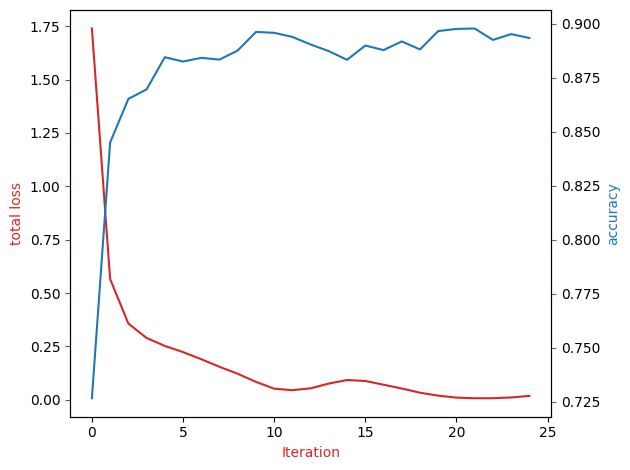

In [29]:
plot_stuff(loss_list,accuracy_list)

### Loading a Pretrained ResNet50 Model and Restoring Checkpoint

1. **Loading the Pretrained Model:**
    - `model = models.resnet50(pretrained=True)`: Loads a pretrained ResNet50 model from the `torchvision.models` module.

2. **Modifying the Fully Connected Layer:**
    - `model.fc = Model(2048, 512, n_classes)`: Replaces the fully connected layer of the ResNet50 model with a custom `Model` class instance. The custom model has an input size of 2048, a hidden size of 512, and an output size equal to the number of classes (`n_classes`).

3. **Loading the Checkpoint:**
    - `checkpoint = torch.load('FashionMNISTClassificationModel.pt')`: Loads the checkpoint from the file `FashionMNISTClassificationModel.pt`.

4. **Restoring the Model State:**
    - `model.load_state_dict(checkpoint['model_state_dict'])`: Loads the model's state dictionary from the checkpoint, restoring the model's parameters.

5. **Restoring the Optimizer State:**
    - `optimizer.load_state_dict(checkpoint['optimizer_state_dict'])`: Loads the optimizer's state dictionary from the checkpoint, restoring the optimizer's parameters.

6. **Restoring Training Information:**
    - `epoch = checkpoint['epoch']`: Restores the number of epochs from the checkpoint.
    - `loss_list = checkpoint['loss']`: Restores the list of loss values from the checkpoint.
    - `accuracy_list = checkpoint['accuracy']`: Restores the list of accuracy values from the checkpoint.
    - `parameters = checkpoint['parameters']`: Restores the training parameters from the checkpoint.

7. **Setting the Model to Evaluation Mode:**
    - `model.eval()`: Sets the model to evaluation mode, which is necessary for inference and ensures that layers like dropout and batch normalization behave appropriately.

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = Model(2048, 512, n_classes)
checkpoint = torch.load('FashionMNISTClassificationModel.pt') 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss']
accuracy_list = checkpoint['accuracy']
parameters = checkpoint['parameters']
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 